#Get data from Kaggle

# **MODEL**

In [1]:
from copy import deepcopy
from dataclasses import dataclass
import multiprocessing as mp
from re import T
import torchvision.models as models
import torch
import copy
import torch.nn.functional as F
#from model import net
import random
import multiprocessing as mp
import os
import os
import torch
import torch.distributed as dist
import torch.multiprocessing as mp
from torchvision import datasets,transforms
import random
from torch import optim,ceil
import torchvision.models as models
import torch.nn.functional as F
from torch import nn
import pickle
import numpy as np
import torchvision.models as models
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
import torch
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
class HistoryStorage():
  

In [13]:
a=pd.read_csv('../Data/data1k.csv')

In [16]:
a=a.sort_values('labels')
a

,Unnamed: 0,image,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab,labels
1292,3373,9af86cc0e38dd156.jpg,1,0,0,0,0,0,0
3471,10731,ca782c131f5ce0fc.jpg,1,0,0,0,0,0,0
5568,7900,b78dc1d9dda30350.jpg,1,0,0,0,1,0,0
3460,10122,c5ce0dc3f197321a.jpg,1,0,0,0,0,0,0
3456,14935,e92a902d573e4aba.jpg,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
2193,11556,d0ad35e0994a9d4f.jpg,0,0,0,0,0,1,5
2191,6396,adfc75ca5818c496.jpg,0,0,0,0,0,1,5
2189,11226,ceb4789d8dc3a425.jpg,0,0,0,0,0,1,5
2265,9460,c1c596cc5eb811b7.jpg,0,0,0,0,0,1,5


In [17]:
a['labels'].value_counts()

5    1599
2    1465
1    1233
0     700
4     617
3     386
Name: labels, dtype: int64

In [20]:
b=a.groupby('labels').head(1599)

In [21]:
b['labels'].value_counts()

5    1599
2    1465
1    1233
0     700
4     617
3     386
Name: labels, dtype: int64

In [2]:

from torch.utils.data import Dataset,DataLoader


class plantdisease(Dataset):
    def __init__(self, train_df='data/raw/train.csv',test_df='data/raw/test.csv'
                 , img_dir='data/oneFolder'
                 , isTest=False,rank=0,central=False,data=None,num_client=20):
        """
        self.isTest (boolean) :test or not
        self.rank
        self.img_labels (csv) : data to generate -> 
        self.shardsList(list(csv)) : list of parts was splitted from train
        self.data (csv) : data server assign to each clients when generate (using self.makeClientDataSet() function to return data for clients )
            path: Server -> create plantdisease(isTest=True,central=True,num_client) -> plantdisease split train - test (use for server evaluation) -> {train} part continue splitted by the number of clients
            -> self.makeClientDataSet(rank) return part of rank^th shardsList
                  Client -> create local plantdiseas(central=False,data= return of server.dataset.makeClientDataSet(rank)) -> trainning
        """
        #Read dataset (balanced.csv is remake dataset that equalized all len(class))
        self.img_labels=pd.read_csv('../Data/data1k.csv')
        self.img_dir='../Data/train_images/'
        #Sort dataset by columns '1' (columns of labels)
        
        #self.img_labels=self.img_labels.drop([i for i in range(2101,5000)],axis=0)

        #If central -> split train - test data
        if central:
            self.train, self.test = train_test_split(self.img_labels, test_size=0.2)
            self.train.reset_index(inplace=True)
            self.test.reset_index(inplace=True)
            if isTest:
                self.img_labels=self.test
                #self.data_csv=self.data_csv.sort_values('labels')
                self.data_csv=self.data_csv
            else:
                self.img_labels=self.train
            #self.img_labels=self.img_labels.sort_values('labels')
            self.img_labels=self.img_labels.sort_values('labels')
        #Split dataset by the number of num_client (so every client would have their own dataset) -> at most a client can contain 2 class of data
            self.shardsList=np.array_split(self.img_labels,num_client)
        else:
            self.data_csv=data
            self.data_csv.reset_index(inplace=True)
        #rank of client
        self.rank=rank
        self.isTest=isTest

        #Check if data exist -> also mean this is client
        if isinstance(data, pd.DataFrame):
            #Assign data to dataset
            self.img_labels=data



        #if rank:
        #    self.img_labels,old_csv=self.make_newCSV()

        #Muon train cung class cho train va test
        #self.train, self.test = train_test_split(self.img_labels, test_size=0.2)
        #self.train, self.test = train_test_split(self.img_labels, test_size=0.05)

            
        #self.test=self.test.append(old_csv)
    def makeClientDataSet(self,rank):
        newCSV=self.shardsList[rank]
        return newCSV

 #   def makeClientDataSet(self,rank):
 #       import random
 #       a=random.randint(0, 5)
 #       b=random.randint(5, 14)
 #       c=random.randint(5, 14)
 #       classList=[rank]
 #       old_csv=self.train
 #       newCSV=old_csv[(old_csv.iloc[:,2].isin(classList) ) ]

        
 #       return newCSV

 #Use to change state of dataset
    def changeisTest(self,boole):
        self.isTest=boole
        #Update img_labels
        if self.isTest:
            self.img_labels=self.test
        else:
            self.img_labels=self.train
    def __len__(self):
        return len(self.img_labels)
    #def make_newCSV(self):
    #    old_csv=self.img_labels
    #    newCSV=old_csv[old_csv.iloc[:,2]==(self.rank)]

        return newCSV,old_csv
    def __getitem__(self, idx):
            img_path = os.path.join(self.img_dir, self.img_labels['image'][idx])

            image = (read_image(img_path).float())
            self.transform=transforms.Compose([
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),transforms.Resize([ 200, 300])])
            image = self.transform(image)
            label = self.img_labels['labels'][idx]

            return image, label

In [4]:
def plotLabelDistribution(x,y,name):
  #X : 
  import plotly.express as px
  fig = px.bar(y=y,x=x,color=x,title='Dataset of '+ name,text_auto=True,labels={'x':'Disease','y':'Counts'})
  fig.show()


In [10]:
plotLabelDistribution(x=data.sample(800).labels.value_counts().keys(),y=data.sample(800).labels.value_counts().values,name='Tes')

NameError: name 'data' is not defined

In [ ]:
a.list_Client[0].dataset.data_csv.labels.value_counts()

0    12
Name: labels, dtype: int64

In [3]:
class Client():
    def __init__(self,id=9999,dataClass=0,initModel=models.mobilenet_v2(pretrained=True),dataset=None,parameters=None):
        self.id=id
        self.dataClass=dataClass
        self.curModel=initModel
        #For test
        #self.curModel.classifier[1]=(torch.nn.Linear(in_features=1280, out_features=15, bias=True))
        #Parameters:
        self.dataset=plantdisease(isTest=False,data=dataset)
        #self.dataset=dataGeneMNIST.MNIST(isTest=False,data=dataset)
        self.learning_rate=parameters['learning_rate']
        self.momentum=parameters['momentum']
        self.batch_size=parameters['batch_size']
        self.local_epoch=parameters['local_epoch']
        self.weight_decay=parameters['weight_decay']
        self.lossHist=[]
    def __len__(self):
        return len(self.dataset)
    def set_learningrate(self,learning_rate):
        self.learning_rate=learning_rate
    def clientID(self):
        print("ID of client: {}".format(self.id))
    def processID(self):
        print("ID of process: {}".format(os.getpid()))



    def client_train(self,lr=0.0003,epoch=10,optimizer=None):
        print("Client , data: {} trainning".format(self.id))
        
        model = self.curModel
        self.optimizer =optim.SGD(model.classifier.parameters(),lr=self.learning_rate,momentum=self.momentum)
        ####

        dataLoader=torch.utils.data.DataLoader(self.dataset,
                                         batch_size=int(self.batch_size),
                                         shuffle=True)

        ######
        for epoc in range(epoch):
            epoc_loss = 0.0
            for data, target in dataLoader:
            #
                #data = data.repeat(1, 3, 1, 1)
            #
                self.optimizer.zero_grad()
                output = model(data)
                loss = torch.nn.CrossEntropyLoss()(output, target)
                epoc_loss += loss.item()
                loss.backward()
                self.optimizer.step()
            
            print('Client ID ', self.id, ', epoch ',
              epoc, ': ', epoc_loss / self.batch_size)
        torch.cuda.empty_cache()
    def client_trainGPU(self,epoch=0):
        lr=self.learning_rate
        
        print("Client {}, data: {} trainning".format(self.id,self.id))
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.curModel.to(device)
        #self.dataset.changeisTest(False)
        ####
        self.optimizer =optim.Adam(self.curModel.parameters(),lr=self.learning_rate,weight_decay=self.weight_decay)
        dataLoader=torch.utils.data.DataLoader(self.dataset,
                                         batch_size=int(self.batch_size),
                                         shuffle=True)

        ######
        for epoc in range(epoch):
            epoc_loss = 0.0
            for data, target in dataLoader:
            #
            #data = data.repeat(1, 3, 1, 1)
            #   
                
                data,target=data.to(device),target.to(device)
                
                
                output = self.curModel(data)
                loss = torch.nn.CrossEntropyLoss()(output, target)

                epoc_loss += loss.item()
                self.optimizer.zero_grad(set_to_none=True)
                loss.backward()
                self.optimizer.step()
            
            print('Client ID ', self.id, ', epoch ',
              epoc, ': ', epoc_loss / self.batch_size)
            self.lossHist.append(epoc_loss)
        self.curModel.to('cpu')
        
    #Hỏng
    def client_evaluate(self):
        self.curModel.eval()
        testDataset=self.dataset
        testDataset.changeisTest(True)
        testDataLoader=torch.utils.data.DataLoader(testDataset,
                                         batch_size=int(20),
                                         shuffle=True)
        test_loss,correct=0,0
        #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.curModel.to(0)
        with torch.no_grad():
            for data,labels in testDataLoader:
                data,labels=data.to(0),labels.to(0)
                outputs=self.curModel(data)
                test_loss+=torch.nn.CrossEntropyLoss()(outputs, labels).item()
                predicted=outputs.argmax(dim=1,keepdim=True)
                print(labels)
                print('-----')
                correct += predicted.eq(labels.view_as(predicted)).sum().item()
                print(predicted)
        test_loss = test_loss / len(testDataLoader)
        test_accuracy=correct/len(testDataset)
        message = f"\t[Client {(self.id)}] ...finished evaluation!\
            \n\t=> Test loss: {test_loss:.4f}\
            \n\t=> Test accuracy: {100. * test_accuracy:.2f}%\n"
        print(message, flush=True)
#a=Client(dataClass=1)
#a.client_trainGPU(epoch=30)
#def saveServer(server):
#    import pickle
#    with open('server.pickle', 'wb') as f:
#        pickle.dump(server, f)
#saveServer(a)
#a.client_evaluate()

class server():
    def __init__(self,tensorboard,parameters):
        self.list_Client=[]
        self.centralModel=models.mobilenet_v2(pretrained=True)
        
        self.centralModel.classifier[1]=(torch.nn.Linear(in_features=1280, out_features=6, bias=True))
        self.centralDataset=plantdisease(isTest=False,rank=None,central=True,num_client=parameters['server']['num_clients'])
        self.parameters=parameters
        self.num_clients=parameters['server']['num_clients']
        self.num_round=parameters['server']['num_round']
        self.num_client_perRound=parameters['server']['num_client_perRound']
        self.isParallel=parameters['server']['isParallel']
        self.local_epoch=parameters['server']['local_epoch']
        self.accuracyHist=[]
        self.lossHist=[]
    def __len__(self):
        return len(self.list_Client)

    def changeLR(self,lr):
        for client in self.list_Client:
            client.set_learningrate(lr)
    def generateClient(self):
        #print('List class {} '.format(dices_classs))
        for i in range(0,self.num_clients):

            #makeClientDataSet(rank) -- with rank is the id of shards data
            datasetTemp=self.centralDataset.makeClientDataSet(rank=i)
            #Assign each client a shard of dataset 
            self.list_Client.append(Client(id=i,dataset=datasetTemp,initModel=copy.deepcopy(self.centralModel),parameters=self.parameters['client']))
        #for i in dices_classs:
        #    if(i>14):
        #        datasetTemp=self.centralDataset.makeClientDataSet(rank=random.randint(0, 10))
        #    else:
        #        datasetTemp=self.centralDataset.makeClientDataSet(rank=i)
        #    self.list_Client.append(client.Client(id=i,dataset=datasetTemp,initModel=copy.deepcopy(self.centralModel),parameters=self.parameters['client']))

    def updateClientModel(self):
        params=self.collectModel()
        paraAverage=self.averageModel(params)
        self.centralModel.load_state_dict(paraAverage)
        
        for idx in self.list_Client:
            #Sửa thử xem load_state_dict lcu1 trước làm việc có đúng ko
            #client.curModel.load_state_dict(paraAverage)
            idx.curModel=copy.deepcopy(self.centralModel)
        print('All clients updated')
    def collectModel(self):
        model_params=[]
        for client in self.Dices:
            model_params.append(client.curModel.state_dict())
        return model_params
    def averageModel(self,params):
        total_len=0
        for i in self.Dices:
            total_len+=len(i)
        listClient_thisRound=self.Dices
        
        #coef=torch.tensor([len(listClient_thisRound[i])/total_len for i in range(0,len(listClient_thisRound)-1)])
        #coef=1/len(listClient_thisRound)
        global_model_weights = copy.deepcopy(self.centralModel.state_dict())
        for key in global_model_weights:
            global_model_weights[key] = torch.zeros_like(
                global_model_weights[key])
        
        #server_params=copy.deepcopy(self.centralModel.parameters())
        for user in listClient_thisRound:
            local_model_weights = copy.deepcopy(user.curModel.state_dict())
            for key in global_model_weights:
                if str(global_model_weights[key].type())!='torch.LongTensor':
                    global_model_weights[key] += (1 / len(listClient_thisRound)) * local_model_weights[key]
        return global_model_weights
        print('finish average')
        #coef=1
        # from collections import OrderedDict
        # paraOut=OrderedDict()
        # for key in params[0]:
        #     if key=='classifier.1.weight' or key=='classifier.1.bias'  :
        #         paraOut[key] = sum([params[i][key]*coef[i] for i in range(0,len(params)-1)])
        #     else:
        #         paraOut[key]=params[0][key]
            #paraOut[key] = sum([params[i][key]*coef[i] for i in range(0,len(params)-1)])
        #return paraOut
        #for i in range(0,len(params)-1):
        #    for key in params[0]:
        #        if i==0:
         #           paraOut[key]=params[i][key]*coef[i]
         #       else:
         #           paraOut[key]+=params[i][key]*coef[i]
    def evaluate_CentralModel(self):
        model=self.centralModel
        model.eval()
        self.centralDataset.changeisTest(True)
        testDataLoader=torch.utils.data.DataLoader(self.centralDataset,
                                         batch_size=int(20),
                                         shuffle=True)
        test_loss,correct=0,0

        with torch.no_grad():
            for data,labels in testDataLoader:
                outputs=self.centralModel(data)


                test_loss+=torch.nn.CrossEntropyLoss()(outputs, labels).item()
                predicted=outputs.argmax(dim=1,keepdim=True)
                print('Labels')
                print(predicted)
                print('------------------------')
                correct += predicted.eq(labels.view_as(predicted)).sum().item()
        test_loss = test_loss / len(testDataLoader)
        test_accuracy=correct/len(self.centralDataset)
        self.accuracyHist.append(test_accuracy)

        self.lossHist.append(test_loss)
        print(self.lossHist)
        print(self.accuracyHist)
        message = f"\t[Central Model ] ...finished evaluation!\
            \n\t=> Test loss: {test_loss:.4f}\
            \n\t=> Test accuracy: {100. * test_accuracy:.2f}%\n"
        print(message, flush=True)
        self.centralDataset.changeisTest(False)

        print('next round')
    def trainClientsQueue(self):
        print("There are {} client in environment".format(len(self.list_Client)))
        from random import sample
        self.Dices=sample(self.list_Client,self.num_client_perRound)
        print("This epoch have clients with id {}".format(self.Dices))
        for client in self.Dices:
            #plotLabelDistribution(x=client.dataset.data_csv.labels.value_counts().keys(),y=client.dataset.data_csv.labels.value_counts(),name='Client '+str(client.id))

            client.client_trainGPU(epoch=self.local_epoch)

        print("Finish train per client")
        self.updateClientModel()
        self.evaluate_CentralModel()
        #print([self.list_Client[idx].id for idx in self.Dices])
    def roundTrain(self):
        self.trainClientsQueue()

In [ ]:
i=1
name='/content/drive/MyDrive/Prethesis-model/server{}.pickle'.format(i)
name

'/content/drive/MyDrive/Prethesis-model/server1.pickle'

In [ ]:
from google.colab import files
uploaded = files.upload()

# **RUN**

FROM BEGINNING

Case {'dataset': 'plantdisease',
 'client': {'learning_rate': 5e-05,
  'momentum': 0.0,
  'weight_decay': 9e-05,
  'batch_size': 30,
  'local_epoch': 1},
 'server': {'num_clients': 100,
  'num_class': 6,
  'num_round': 100,
  'num_client_perRound': 50,
  'isParallel': 'False',
  'model': 'mobilenetv3',
  'local_epoch': 10}}

In [4]:
info={'dataset': 'plantdisease',
 'client': {'learning_rate': 5e-05,
  'momentum': 0.0,
  'weight_decay': 9e-05,
  'batch_size': 30,
  'local_epoch': 1},
 'server': {'num_clients': 100,
  'num_class': 6,
  'num_round': 100,
  'num_client_perRound': 50,
  'isParallel': 'False',
  'model': 'mobilenetv3',
  'local_epoch': 10}}
from importlib.abc import Loader
import yaml
from yaml.loader import SafeLoader


if __name__ == '__main__':
    def saveServer(server):
        import pickle
        with open('./model2.pickle', 'wb') as f:
            pickle.dump(server, f)

    a=server(tensorboard=0,parameters=info)
    a.generateClient()
    for i in range(0,info['server']['num_round']):
      print("Round {}".format(i))
      a.roundTrain()
      if(i%5==0):
        print('Server saved {}'.format(i))
        saveServer(a)
    #writer.flush()

Round 0
There are 100 client in environment
This epoch have clients with id [<__main__.Client object at 0x000001ECE4CADEB0>, <__main__.Client object at 0x000001ECF9375E50>, <__main__.Client object at 0x000001EC83F53970>, <__main__.Client object at 0x000001ECFFD61D30>, <__main__.Client object at 0x000001ECF307FEB0>, <__main__.Client object at 0x000001ECD036C340>, <__main__.Client object at 0x000001ECFADDE280>, <__main__.Client object at 0x000001ECD0C5F190>, <__main__.Client object at 0x000001EC8567E850>, <__main__.Client object at 0x000001ECE1E68D30>, <__main__.Client object at 0x000001EC8A9A6E50>, <__main__.Client object at 0x000001ECD1229310>, <__main__.Client object at 0x000001ECD034EA30>, <__main__.Client object at 0x000001EC85D88DF0>, <__main__.Client object at 0x000001ECDB5398B0>, <__main__.Client object at 0x000001EC85A16C40>, <__main__.Client object at 0x000001ECF43FAEB0>, <__main__.Client object at 0x000001ECD6C9ED00>, <__main__.Client object at 0x000001ECF78EDFA0>, <__main__.C

In [6]:
len(a.list_Client[0])

57

In [15]:
a=pd.read_csv('../Data/data1k.csv')

In [18]:
a

,Unnamed: 0,image,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab,labels
0,18165,fda1898fb8d05ad0.jpg,0,0,0,0,0,1,5
1,14900,e8f0da91d370692d.jpg,0,1,0,0,0,0,1
2,4993,a6da180e03fce94f.jpg,0,1,0,0,0,1,1
3,11216,cea4b5c20b839f0f.jpg,0,0,0,0,0,1,5
4,14637,e70cc58572bcc35c.jpg,0,0,1,0,0,0,2
...,...,...,...,...,...,...,...,...,...
5995,17392,f915b2fa58e9e018.jpg,0,0,0,0,0,1,5
5996,3775,9f9c55656a4592b2.jpg,0,0,1,0,0,0,2
5997,1921,8f8fe24b80e21cb7.jpg,1,0,0,0,0,0,0
5998,4017,a0d05afa7825e5f4.jpg,0,0,0,0,0,1,5


In [23]:
a.iloc[:,2:-1].sum(axis=1)

0       1
1       1
2       2
3       1
4       1
       ..
5995    1
5996    1
5997    1
5998    1
5999    1
Length: 6000, dtype: int64

In [ ]:
!cp -b /content/drive/MyDrive/Prethesis-model/server1.pickle /content/drive/MyDrive/Prethesis-model/server1backup.pickle


In [5]:
import pickle
info={'dataset': 'plantdisease',
 'client': {'learning_rate': 5e-05,
  'momentum': 0.0,
  'weight_decay': 9e-05,
  'batch_size': 30,
  'local_epoch': 1},
 'server': {'num_clients': 100,
  'num_class': 6,
  'num_round': 100,
  'num_client_perRound': 15,
  'isParallel': 'False',
  'model': 'mobilenetv3',
  'local_epoch': 10}}
from importlib.abc import Loader
import yaml
from yaml.loader import SafeLoader
conti=[]

def saveServer(server):
  import pickle
  with open('./model1.pickle', 'wb') as f:
    pickle.dump(server, f)
if __name__ == '__main__':

  with open('./model1.pickle', 'rb') as f:
    conti=pickle.load(f)
    #from torch.utils.tensorboard import SummaryWriter
    #writer = SummaryWriter()
    f.close()

In [7]:
(conti.accuracyHist)

[0.2225,
 0.23333333333333334,
 0.27,
 0.2658333333333333,
 0.26916666666666667,
 0.2658333333333333,
 0.26916666666666667,
 0.27166666666666667,
 0.18833333333333332,
 0.2658333333333333,
 0.26916666666666667,
 0.4508333333333333,
 0.18833333333333332,
 0.2658333333333333,
 0.1575,
 0.26916666666666667,
 0.26666666666666666,
 0.26916666666666667,
 0.49166666666666664,
 0.415,
 0.3625,
 0.2658333333333333,
 0.455,
 0.33916666666666667,
 0.3375,
 0.27666666666666667,
 0.18916666666666668,
 0.3775,
 0.3125,
 0.2658333333333333,
 0.49083333333333334,
 0.4825,
 0.26916666666666667,
 0.36583333333333334,
 0.2658333333333333,
 0.325,
 0.4275,
 0.2991666666666667,
 0.27666666666666667,
 0.29583333333333334,
 0.44,
 0.26916666666666667,
 0.445,
 0.3958333333333333,
 0.2658333333333333,
 0.2725,
 0.30833333333333335,
 0.3458333333333333,
 0.33916666666666667,
 0.27166666666666667,
 0.29333333333333333,
 0.48,
 0.38333333333333336,
 0.2658333333333333,
 0.43666666666666665,
 0.2658333333333333,


In [12]:
conti.list_Client[2].dataset.img_labels

,level_0,index,Unnamed: 0,image,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab,labels
0,5562,1845,11092,cd9698463a3df270.jpg,1,0,0,0,0,0,0
1,519,59,141,80d457877e3d1cb8.jpg,1,0,0,0,0,0,0
2,4780,3763,4903,a5e5db6960b4c683.jpg,1,1,0,0,0,1,0
3,521,5061,5163,a88795d8d2398b3d.jpg,1,0,0,1,0,0,0
4,4781,5283,8346,bbb9d4980dac9269.jpg,1,0,0,0,0,0,0
5,3430,3126,9587,c26e3f0170abb19d.jpg,1,0,0,0,0,0,0
6,3427,5756,1341,8a16276936ea7aca.jpg,1,0,0,0,0,0,0
7,528,3022,2687,955b9ac5cc86949b.jpg,1,1,0,0,0,1,0
8,3423,3011,1103,87e53a22ef6151b8.jpg,1,0,0,0,0,0,0
9,4790,104,6344,adce1acf885c7514.jpg,1,0,0,0,0,0,0


In [7]:
with open('./model.pickle', 'rb') as f:
    conti=pickle.load(f)
    #from torch.utils.tensorboard import SummaryWriter
    #writer = SummaryWriter()
    f.close()

EOFError: Ran out of input

In [12]:
import matplotlib.pyplot as plt

In [9]:
len(conti.accuracyHist)

21

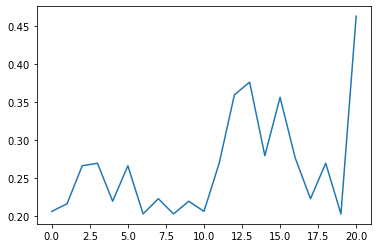

In [17]:
plt.plot(conti.accuracyHist)

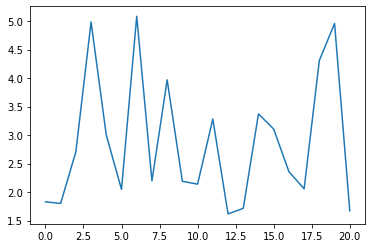

In [18]:
plt.plot(conti.lossHist)

In [15]:
max(conti.accuracyHist)

0.4633333333333333

In [17]:
min(conti.lossHist)

0.4228292261560758

In [19]:
for i in range(0,info['server']['num_round']):
    print("Round {}".format(i))
    conti.roundTrain()
    if(i%2==0):
        print('Server saved {}'.format(i))
        saveServer(conti)

Round 0
There are 100 client in environment
This epoch have clients with id [<__main__.Client object at 0x000001369CF9B820>, <__main__.Client object at 0x0000013705AD6A00>, <__main__.Client object at 0x000001372B346F10>, <__main__.Client object at 0x00000136A979DDF0>, <__main__.Client object at 0x0000013701A28460>, <__main__.Client object at 0x00000137464AB0D0>, <__main__.Client object at 0x00000136AEA355E0>, <__main__.Client object at 0x00000136894A7EE0>, <__main__.Client object at 0x000001371E51EBE0>, <__main__.Client object at 0x00000136E8D4D340>, <__main__.Client object at 0x00000137432796A0>, <__main__.Client object at 0x00000136205F2310>, <__main__.Client object at 0x000001369E569D60>, <__main__.Client object at 0x000001367F973310>, <__main__.Client object at 0x0000013614E6CB20>]
Client 70, data: 70 trainning
Client ID  70 , epoch  0 :  0.12476300597190856
Client ID  70 , epoch  1 :  0.006978047390778859
Client ID  70 , epoch  2 :  0.00043163683731108906
Client ID  70 , epoch  3 

In [10]:
(conti.accuracyHist)

[0.46,
 0.6266666666666667,
 0.7633333333333333,
 0.7966666666666666,
 0.82,
 0.8233333333333334,
 0.8366666666666667,
 0.8433333333333334,
 0.8466666666666667,
 0.85,
 0.8466666666666667,
 0.85,
 0.86,
 0.8666666666666667,
 0.8633333333333333,
 0.8733333333333333,
 0.87,
 0.8733333333333333,
 0.8766666666666667,
 0.88,
 0.8866666666666667,
 0.8666666666666667,
 0.8766666666666667,
 0.8866666666666667,
 0.8833333333333333,
 0.8733333333333333,
 0.8833333333333333,
 0.8933333333333333,
 0.89,
 0.89,
 0.89,
 0.8833333333333333,
 0.89,
 0.8966666666666666,
 0.89,
 0.8866666666666667]

In [ ]:
len(conti.accuracyHist)

43

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [ ]:
torch.save(conti.centralModel.state_dict(), 'parameter.pth')

Text(0, 0.5, 'Accuracy')

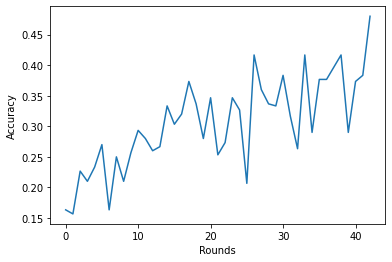

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(0,len(conti.accuracyHist)),conti.accuracyHist,)
plt.xlabel("Rounds")
plt.ylabel("Accuracy")


Text(0, 0.5, 'Loss History')

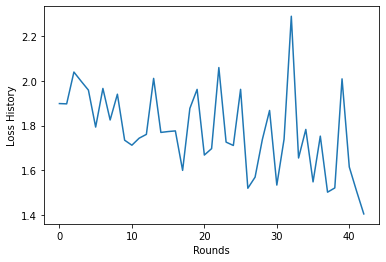

In [ ]:
plt.plot(range(0,len(conti.accuracyHist)),conti.lossHist,)
plt.xlabel("Rounds")
plt.ylabel("Loss History")

In [ ]:
a=[1.8987637519836427, 1.8974739154179892, 2.040224885940552, 1.9990726629892985, 1.959251054128011, 1.7933303674062093, 1.9666422128677368, 1.825169316927592, 1.9407729864120484, 1.7343559583028159, 1.711883536974589, 1.7433618625005087, 1.7605376640955608, 2.011758049329122, 1.7692884127298991, 1.7731905698776245, 1.7760921080907186, 1.5990015029907227, 1.877139433224996, 1.9624298254648844, 1.6677559773127237, 1.69661279519399, 2.0603761355082195, 1.7258090734481812, 1.7107341527938842, 1.962593142191569, 1.518720022837321, 1.5685885270436606, 1.737037189801534, 1.8678918679555256, 1.5330387671788535, 1.738879934946696, 2.290648682912191, 1.6545614878336588, 1.7826974074045816, 1.5473427534103394, 1.752670987447103, 1.5011515061060587, 1.5201624870300292, 2.0096364259719848, 1.6141677856445313, 1.5065311829249064, 1.403585934638977, 1.811416776974996]
len(a)

44

In [ ]:
import joblib 

In [ ]:
joblib.load(open('/content/drive/MyDrive/Prethesis-model/server1 (1).pickle', 'rb'))

KeyError: ignored

Continue Running

In [ ]:
info={'dataset': 'plantdisease',
 'client': {'learning_rate': 1e-05,
  'momentum': 0.0,
  'weight_decay': 1e-05,
  'batch_size': 25
  },
 'server': {'num_clients': 100,
  'num_class': 6,
  'num_round': 100,
  'num_client_perRound': 25,
  'isParallel': 'False',
  'model': 'mobilenetv3',
  'local_epoch': 10}}
best_acc=[999]

from importlib.abc import Loader
import yaml
from yaml.loader import SafeLoader
#Continue 
if __name__ == '__main__':
  def saveServer(server):
    import pickle
    with open('/content/server1.pickle', 'wb') as f:
      pickle.dump(server, f)
      f.close()
    #with open('/content/drive/MyDrive/Prethesis-model/server1.pickle', 'wb') as f:
    #  pickle.dump(server, f)
    #  f.close()
  def saveBestAServer(server,acc):
    import pickle
    with open('/content/drive/MyDrive/Prethesis-model/serverBest.pickle', 'wb') as f:
      pickle.dump(server, f)
      f.close()
    with open('/content/serverBest.pickle', 'wb') as f:
      pickle.dump(server, f)
      f.close()
  def saveBestLServer(server,loss):
    import pickle
    with open('/content/drive/MyDrive/Prethesis-model/serverBestL.pickle', 'wb') as f:
      pickle.dump(server, f)
      print('another best, {} loss'.format(loss))
      f.close()
    with open('/content/serverBestL.pickle', 'wb') as f:
      pickle.dump(server, f)
      f.close()

  import pickle
  with open('/content/drive/MyDrive/Prethesis-model/serverBest.pickle', 'rb') as f:
    conti=pickle.load(f)
    #from torch.utils.tensorboard import SummaryWriter
    #writer = SummaryWriter()
    f.close()
  for i in range(0,info['server']['num_round']):
    print("Round {}".format(len(conti.accuracyHist)))
    conti.roundTrain()
    if conti.accuracyHist[-1]>max(conti.accuracyHist[:-2]):
      saveBestServer(conti,conti.accuracyHist[-1])
    if conti.lossHist[-1]<min(conti.lossHist[:-2]):
      saveBestLServer(conti,conti.lossHist[-1])
    if i%4==0:
      saveServer(conti)
    torch.save(conti.centralModel.state_dict(), '/content/parameter.pt')

KeyboardInterrupt: ignored

Temp

In [ ]:
!cp -b /content/drive/MyDrive/Prethesis-model/server1.pickle /content/drive/MyDrive/Prethesis-model/server1backup.pickle

In [ ]:
import pickle
with open('/content/drive/MyDrive/Prethesis-model/server2.pickle', 'rb') as f:
  contiServer=pickle.load(f)
for i in range(0,info['server']['num_round']):
  print("Round {}".format(i))
  a.roundTrain()
  saveServer(a)

In [ ]:
import os
scores=0
unpickler=0
if os.path.getsize('/content/drive/MyDrive/Prethesis-model/server2.pickle') > 0:      
    with open('/content/drive/MyDrive/Prethesis-model/server2.pickle', "rb") as f:
        unpickler = pickle.Unpickler(f)
        # if file is not empty scores will be equal
        # to the value unpickled
        scores = unpickler.load()
        print(unpickler,scores)

<_pickle.Unpickler object at 0x7f4df5d6b4d0> <__main__.server object at 0x7f4df624e550>


In [ ]:
unpickler

In [ ]:
import pickle
file = open("Fruits.obj",'rb')


In [ ]:
info={'dataset': 'plantdisease',
 'client': {'learning_rate': 7e-06,
  'momentum': 0.0,
  'weight_decay': 1e-05,
  'batch_size': 25,
  'local_epoch': 1},
 'server': {'num_clients': 100,
  'num_class': 6,
  'num_round': 100,
  'num_client_perRound': 25,
  'isParallel': 'False',
  'model': 'mobilenetv3',
  'local_epoch': 10}}
from importlib.abc import Loader
import yaml
from yaml.loader import SafeLoader



if __name__ == '__main__':
    def saveServer(server,i):
        import pickle
        name='/content/drive/MyDrive/Prethesis-model/server{}.pickle'.format(i)
        with open(name, 'wb') as f:
            pickle.dump(server, f)
        print('savedModel')
        
    from torch.utils.tensorboard import SummaryWriter
    #writer = SummaryWriter(
    a=server(tensorboard=0,parameters=info)
    a.generateClient()
    for i in range(0,info['server']['num_round']):
    
      print("Round {}".format(i))
      a.roundTrain()
      if i%4==0:
        saveServer(a,1)
    
    #writer.flush()

KeyboardInterrupt: ignored